# Astronomical Image Reconstruction using Autoencoder
We will demonstrate image reconstruction of images of galaxies in Messier Catalog using Autoencoder. De-noising autoencoders can be trained for deconvolution and removal of noise.

In [1]:
from mirapy.data.load_dataset import load_messier_catalog_images, prepare_messier_catalog_images
from mirapy.utils import get_psf_airy, image_augmentation, append_one_to_shape, psnr
from mirapy.autoencoder.models import DeNoisingAutoencoder

from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam
import numpy as np
import scipy

Using TensorFlow backend.


In [2]:
data_dir = '../../image-denoising-network/messier_catalog_galaxies'
img_dim = (256, 256)

npsf=64
nr=5

sigma=0.1

We will load the data set and reshape it to 256x256.

In [3]:
images = load_messier_catalog_images(data_dir, img_dim)

100%|██████████| 39/39 [00:13<00:00,  2.95it/s]


We have 39 images in total. Firstly, we will take 4 test images and apply various data augmentation to increase the size of training set.

In [4]:
X_train, X_test = train_test_split(images, test_size=0.10, random_state=42)

In [5]:
datagen = ImageDataGenerator(rotation_range=40,
                             width_shift_range=0.2,
                             height_shift_range=0.2,
                             zoom_range=0.2,
                             horizontal_flip=True)

X_train = image_augmentation(X_train, datagen, 20)

100%|██████████| 35/35 [00:02<00:00, 13.45it/s]


Following is the PSF function used for convolution:

```
def get_psf_airy(n, nr):
    xpsf = np.linspace(-1, 1, n)
    xg, yg = np.meshgrid(xpsf, xpsf)
    r = np.sqrt(xg**2+yg**2)*np.pi*nr
    psf = (scipy.special.j1(r)/r)**2
    psf = psf/psf.sum()
    return psf
```

You can also import it from `mirapy.utils` module.

In [6]:
psf = get_psf_airy(npsf, nr)

It is time to prepare datasets by applying convolution and adding noise from Poisson distribution.

In [7]:
X_train, x_train_noisy = prepare_messier_catalog_images(X_train, psf=psf, sigma=sigma)
X_test, x_test_noisy = prepare_messier_catalog_images(X_test, psf=psf, sigma=sigma)

We reshape the image to append `1` that represents the grayscale channel.

In [8]:
X_train = append_one_to_shape(X_train)
X_test = append_one_to_shape(X_test)
x_train_noisy = append_one_to_shape(np.array(x_train_noisy))
x_test_noisy = append_one_to_shape(np.array(x_test_noisy))

We are done with data pre-processing of images! Now it's time to build the autoencoder model. We can tune parameters to see how the network performs.

In [9]:
autoencoder = DeNoisingAutoencoder(img_dim, 'relu', 'same')

Following are the four examples of input and output images.

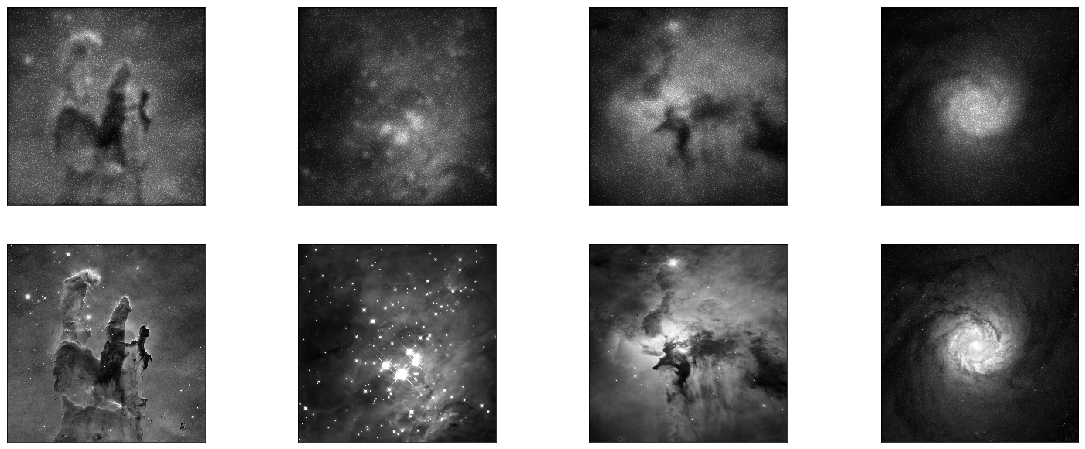

In [10]:
autoencoder.show_image_pairs(x_test_noisy, X_test, 4)

We will use `Adam` optimizer class in Keras and mean squared error as the loss function.

In [11]:
adam = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
autoencoder.compile(adam, 'mean_squared_error')

Here, we will use the noisy and original images of test set for validation.

In [12]:
autoencoder.train(x_train_noisy, X_train, epochs=1000, validation_data=(x_test_noisy, X_test), verbose=2)

Train on 700 samples, validate on 4 samples
Epoch 1/1000
 - 30s - loss: 0.0358 - val_loss: 0.0148
Epoch 2/1000
 - 16s - loss: 0.0140 - val_loss: 0.0221
Epoch 3/1000
 - 16s - loss: 0.0076 - val_loss: 0.0141
Epoch 4/1000
 - 16s - loss: 0.0053 - val_loss: 0.0109
Epoch 5/1000
 - 16s - loss: 0.0031 - val_loss: 0.0064
Epoch 6/1000
 - 16s - loss: 0.0028 - val_loss: 0.0064
Epoch 7/1000
 - 16s - loss: 0.0028 - val_loss: 0.0108
Epoch 8/1000
 - 16s - loss: 0.0034 - val_loss: 0.0047
Epoch 9/1000
 - 16s - loss: 0.0027 - val_loss: 0.0053
Epoch 10/1000
 - 16s - loss: 0.0028 - val_loss: 0.0052
Epoch 11/1000
 - 16s - loss: 0.0026 - val_loss: 0.0037
Epoch 12/1000
 - 16s - loss: 0.0028 - val_loss: 0.0049
Epoch 13/1000
 - 16s - loss: 0.0026 - val_loss: 0.0034
Epoch 14/1000
 - 16s - loss: 0.0030 - val_loss: 0.0050
Epoch 15/1000
 - 16s - loss: 0.0027 - val_loss: 0.0031
Epoch 16/1000
 - 16s - loss: 0.0025 - val_loss: 0.0034
Epoch 17/1000
 - 16s - loss: 0.0025 - val_loss: 0.0038
Epoch 18/1000
 - 16s - loss: 0

Epoch 149/1000
 - 16s - loss: 0.0021 - val_loss: 0.0028
Epoch 150/1000
 - 16s - loss: 0.0023 - val_loss: 0.0023
Epoch 151/1000
 - 16s - loss: 0.0020 - val_loss: 0.0022
Epoch 152/1000
 - 17s - loss: 0.0019 - val_loss: 0.0021
Epoch 153/1000
 - 16s - loss: 0.0022 - val_loss: 0.0044
Epoch 154/1000
 - 16s - loss: 0.0020 - val_loss: 0.0023
Epoch 155/1000
 - 16s - loss: 0.0020 - val_loss: 0.0029
Epoch 156/1000
 - 16s - loss: 0.0019 - val_loss: 0.0020
Epoch 157/1000
 - 16s - loss: 0.0018 - val_loss: 0.0024
Epoch 158/1000
 - 16s - loss: 0.0017 - val_loss: 0.0021
Epoch 159/1000
 - 16s - loss: 0.0018 - val_loss: 0.0020
Epoch 160/1000
 - 16s - loss: 0.0018 - val_loss: 0.0032
Epoch 161/1000
 - 16s - loss: 0.0020 - val_loss: 0.0031
Epoch 162/1000
 - 16s - loss: 0.0018 - val_loss: 0.0026
Epoch 163/1000
 - 16s - loss: 0.0020 - val_loss: 0.0059
Epoch 164/1000
 - 16s - loss: 0.0018 - val_loss: 0.0022
Epoch 165/1000
 - 16s - loss: 0.0018 - val_loss: 0.0022
Epoch 166/1000
 - 16s - loss: 0.0018 - val_loss:

Epoch 296/1000
 - 16s - loss: 0.0016 - val_loss: 0.0028
Epoch 297/1000
 - 16s - loss: 0.0018 - val_loss: 0.0095
Epoch 298/1000
 - 16s - loss: 0.0019 - val_loss: 0.0067
Epoch 299/1000
 - 16s - loss: 0.0016 - val_loss: 0.0058
Epoch 300/1000
 - 16s - loss: 0.0017 - val_loss: 0.0018
Epoch 301/1000
 - 16s - loss: 0.0015 - val_loss: 0.0027
Epoch 302/1000
 - 16s - loss: 0.0016 - val_loss: 0.0019
Epoch 303/1000
 - 16s - loss: 0.0018 - val_loss: 0.0024
Epoch 304/1000
 - 16s - loss: 0.0019 - val_loss: 0.0019
Epoch 305/1000
 - 16s - loss: 0.0018 - val_loss: 0.0022
Epoch 306/1000
 - 16s - loss: 0.0017 - val_loss: 0.0020
Epoch 307/1000
 - 16s - loss: 0.0016 - val_loss: 0.0019
Epoch 308/1000
 - 16s - loss: 0.0015 - val_loss: 0.0020
Epoch 309/1000
 - 16s - loss: 0.0016 - val_loss: 0.0022
Epoch 310/1000
 - 16s - loss: 0.0016 - val_loss: 0.0037
Epoch 311/1000
 - 16s - loss: 0.0016 - val_loss: 0.0021
Epoch 312/1000
 - 16s - loss: 0.0017 - val_loss: 0.0043
Epoch 313/1000
 - 16s - loss: 0.0016 - val_loss:

Epoch 443/1000
 - 17s - loss: 0.0016 - val_loss: 0.0020
Epoch 444/1000
 - 17s - loss: 0.0014 - val_loss: 0.0020
Epoch 445/1000
 - 16s - loss: 0.0015 - val_loss: 0.0018
Epoch 446/1000
 - 16s - loss: 0.0015 - val_loss: 0.0032
Epoch 447/1000
 - 17s - loss: 0.0015 - val_loss: 0.0023
Epoch 448/1000
 - 17s - loss: 0.0014 - val_loss: 0.0023
Epoch 449/1000
 - 17s - loss: 0.0015 - val_loss: 0.0029
Epoch 450/1000
 - 17s - loss: 0.0014 - val_loss: 0.0018
Epoch 451/1000
 - 16s - loss: 0.0014 - val_loss: 0.0031
Epoch 452/1000
 - 17s - loss: 0.0014 - val_loss: 0.0018
Epoch 453/1000
 - 17s - loss: 0.0015 - val_loss: 0.0027
Epoch 454/1000
 - 17s - loss: 0.0015 - val_loss: 0.0025
Epoch 455/1000
 - 17s - loss: 0.0016 - val_loss: 0.0054
Epoch 456/1000
 - 17s - loss: 0.0015 - val_loss: 0.0020
Epoch 457/1000
 - 17s - loss: 0.0014 - val_loss: 0.0018
Epoch 458/1000
 - 17s - loss: 0.0014 - val_loss: 0.0022
Epoch 459/1000
 - 17s - loss: 0.0016 - val_loss: 0.0056
Epoch 460/1000
 - 17s - loss: 0.0016 - val_loss:

Epoch 590/1000
 - 17s - loss: 0.0014 - val_loss: 0.0017
Epoch 591/1000
 - 17s - loss: 0.0014 - val_loss: 0.0017
Epoch 592/1000
 - 16s - loss: 0.0014 - val_loss: 0.0023
Epoch 593/1000
 - 17s - loss: 0.0015 - val_loss: 0.0053
Epoch 594/1000
 - 17s - loss: 0.0014 - val_loss: 0.0017
Epoch 595/1000
 - 16s - loss: 0.0013 - val_loss: 0.0021
Epoch 596/1000
 - 17s - loss: 0.0014 - val_loss: 0.0018
Epoch 597/1000
 - 17s - loss: 0.0016 - val_loss: 0.0035
Epoch 598/1000
 - 17s - loss: 0.0014 - val_loss: 0.0024
Epoch 599/1000
 - 17s - loss: 0.0014 - val_loss: 0.0017
Epoch 600/1000
 - 17s - loss: 0.0014 - val_loss: 0.0018
Epoch 601/1000
 - 17s - loss: 0.0014 - val_loss: 0.0018
Epoch 602/1000
 - 17s - loss: 0.0014 - val_loss: 0.0021
Epoch 603/1000
 - 17s - loss: 0.0014 - val_loss: 0.0017
Epoch 604/1000
 - 16s - loss: 0.0013 - val_loss: 0.0018
Epoch 605/1000
 - 17s - loss: 0.0013 - val_loss: 0.0017
Epoch 606/1000
 - 17s - loss: 0.0013 - val_loss: 0.0017
Epoch 607/1000
 - 16s - loss: 0.0015 - val_loss:

Epoch 737/1000
 - 16s - loss: 0.0013 - val_loss: 0.0016
Epoch 738/1000
 - 17s - loss: 0.0013 - val_loss: 0.0019
Epoch 739/1000
 - 16s - loss: 0.0013 - val_loss: 0.0033
Epoch 740/1000
 - 16s - loss: 0.0013 - val_loss: 0.0018
Epoch 741/1000
 - 17s - loss: 0.0013 - val_loss: 0.0020
Epoch 742/1000
 - 17s - loss: 0.0014 - val_loss: 0.0019
Epoch 743/1000
 - 16s - loss: 0.0017 - val_loss: 0.0023
Epoch 744/1000
 - 17s - loss: 0.0015 - val_loss: 0.0021
Epoch 745/1000
 - 17s - loss: 0.0014 - val_loss: 0.0018
Epoch 746/1000
 - 17s - loss: 0.0014 - val_loss: 0.0031
Epoch 747/1000
 - 17s - loss: 0.0013 - val_loss: 0.0019
Epoch 748/1000
 - 17s - loss: 0.0014 - val_loss: 0.0019
Epoch 749/1000
 - 16s - loss: 0.0014 - val_loss: 0.0024
Epoch 750/1000
 - 17s - loss: 0.0013 - val_loss: 0.0023
Epoch 751/1000
 - 16s - loss: 0.0013 - val_loss: 0.0029
Epoch 752/1000
 - 16s - loss: 0.0014 - val_loss: 0.0022
Epoch 753/1000
 - 16s - loss: 0.0014 - val_loss: 0.0022
Epoch 754/1000
 - 16s - loss: 0.0014 - val_loss:

Epoch 884/1000
 - 16s - loss: 0.0014 - val_loss: 0.0020
Epoch 885/1000
 - 16s - loss: 0.0014 - val_loss: 0.0036
Epoch 886/1000
 - 16s - loss: 0.0014 - val_loss: 0.0032
Epoch 887/1000
 - 16s - loss: 0.0013 - val_loss: 0.0022
Epoch 888/1000
 - 16s - loss: 0.0013 - val_loss: 0.0017
Epoch 889/1000
 - 17s - loss: 0.0013 - val_loss: 0.0017
Epoch 890/1000
 - 17s - loss: 0.0013 - val_loss: 0.0026
Epoch 891/1000
 - 17s - loss: 0.0013 - val_loss: 0.0017
Epoch 892/1000
 - 17s - loss: 0.0013 - val_loss: 0.0017
Epoch 893/1000
 - 17s - loss: 0.0013 - val_loss: 0.0016
Epoch 894/1000
 - 17s - loss: 0.0013 - val_loss: 0.0024
Epoch 895/1000
 - 17s - loss: 0.0013 - val_loss: 0.0019
Epoch 896/1000
 - 17s - loss: 0.0013 - val_loss: 0.0018
Epoch 897/1000
 - 17s - loss: 0.0013 - val_loss: 0.0022
Epoch 898/1000
 - 16s - loss: 0.0013 - val_loss: 0.0017
Epoch 899/1000
 - 17s - loss: 0.0014 - val_loss: 0.0017
Epoch 900/1000
 - 16s - loss: 0.0014 - val_loss: 0.0028
Epoch 901/1000
 - 16s - loss: 0.0014 - val_loss:

Now, we will denoise the test images and show the results:

In [13]:
decoded_imgs = autoencoder.predict(x_test_noisy)

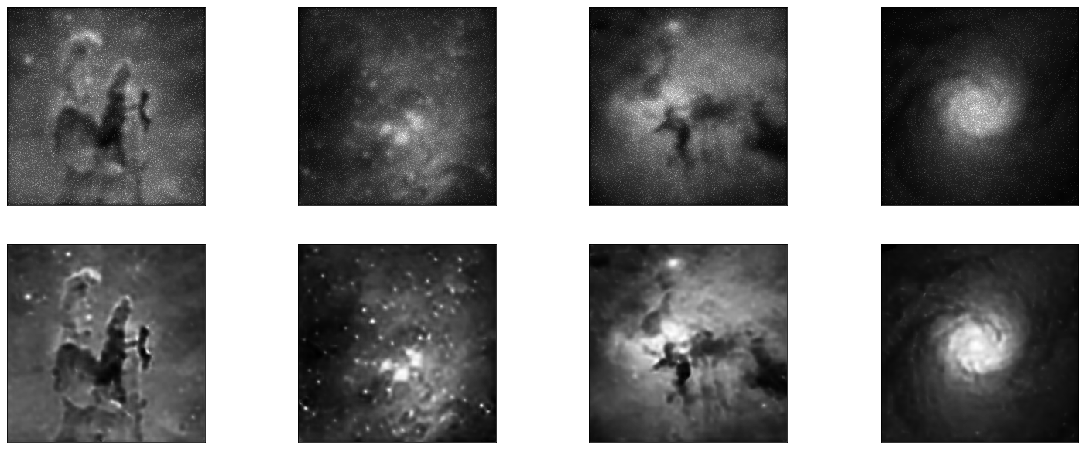

In [14]:
autoencoder.show_image_pairs(x_test_noisy, decoded_imgs, 4)

We will compute peak signal to noise ratio (PSNR) for an image:

In [15]:
psnr(x_test_noisy[0], decoded_imgs[0])

21.809265693234586

## Comparing results
It is time to compare our result with:

- Wiener-Hunt deconvolution
- Richardson-Lucy deconvolution
- Total-variation denoising

In [16]:
from skimage import color, data, restoration

/home/swapsha96/anaconda3/lib/python3.6/site-packages/dask/config.py:168: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = yaml.load(f.read()) or {}


In [17]:
nimg = x_test_noisy[0].reshape((256, 256))
decoded_rl = restoration.richardson_lucy(nimg, get_psf_airy(npsf, nr), 2)
decoded_w = restoration.wiener(nimg, get_psf_airy(npsf, nr), 1100)
decoded_tv = restoration.denoise_tv_chambolle(nimg, 5, n_iter_max=100, eps=0.002, multichannel=False)

d_rl = psnr(x_test_noisy[0], decoded_rl)
d_w = psnr(x_test_noisy[0], decoded_w)
d_tv = psnr(x_test_noisy[0], decoded_tv)
d = psnr(x_test_noisy[0], decoded_imgs[0])

In [18]:
d_rl, d_w, d_tv, d

(16.554692355075037,
 17.155958381512495,
 17.053849655979157,
 21.809265693234586)

Here, we see that our proposed model outperforms the results of standard image restoration techniques!